In [1]:
import utils
import qiskit
import qiskit_aer
import numpy as np
from math import log
import qiskit.visualization
import matplotlib.pyplot as plt
from qiskit.circuit.library.standard_gates import RYGate

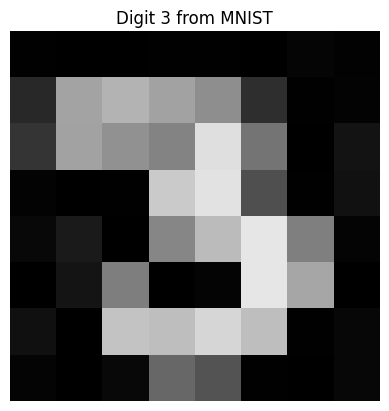

In [2]:
image = utils.plot_image('images/three_8by8.jpg', 'Digit 3 from MNIST')

$$|I(\theta)\rangle=\frac 1{2^n}\sum_{i=0}^{2^{2n}-1}|c_i\rangle\otimes|i\rangle$$

$$|c_i\rangle = \cos\theta_i |0\rangle + \sin \theta_i |1\rangle$$

In [3]:
def equal_superposition(circ: qiskit.QuantumCircuit, targets: int):
    for idx in range(targets): 
        circ.h(idx)
        
def iterate(circ: qiskit.QuantumCircuit, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    #   - We reverse the state strings because we set the coordinates qubits in the circuit
    #       in descending order.
    x_targets = np.array([idx for idx in range(n) 
                          if current_state[::-1][idx] != next_state[::-1][idx]])

    # Example
    # 1110 -> 1111
    #   if we don't reverse the strings we get:
    #   x_targets = [3]
    #   thus we will apply the X gate on the fourth qubit.
    #   but this is not what we want, we should apply it to the first qubit.
    #   think little endian vs big endian
    
    if x_targets.size > 0:
        circ.x(x_targets)

def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, target: int, intensity: float):
    # Making the C^nRY manually improves visualization
    cry = RYGate(2 * intensity).control(len(control))
    aux = np.append(control, target).tolist()
    circ.append(cry, aux)

In [4]:
def construct_frqi(circ: qiskit.QuantumCircuit, control: list, 
                   target: qiskit.QuantumRegister, image: np.array):
    
    num_qubits = circ.num_qubits
    equal_superposition(circ, num_qubits - 1) # Only positional qubits are in a superposition.
    
    for idx, angle in enumerate(image):
        # We make a binary string representation of `idx``
        #   of length `num_qubits - 1` (we only operate on coordinate qubits).
        state = '{0:0{1}b}'.format(idx-1, num_qubits -1) 
        next_state = '{0:0{1}b}'.format(idx, num_qubits - 1)
        
        if idx > 0:
            iterate(circ, state, next_state)
        
        pixel_encoding(circ, control, target, angle)
        circ.barrier()
    
    to_measure = [*range(num_qubits)]
    circ.measure(to_measure, to_measure)

In [5]:
flat_ang_rep = utils.get_angle_representation(image,
                                                min_val=0,
                                                max_val=255)

n = int(log(image.shape[0], 2))

# FRQI requires 2n + 1 qubits.
qcord_register  = qiskit.QuantumRegister(2 * n, 'cord') 
qcolor_register = qiskit.QuantumRegister(1, 'color') 
creg = qiskit.ClassicalRegister(2 * n +1, 'bits')

In [6]:
frqi_circ = qiskit.QuantumCircuit(qcord_register, qcolor_register, creg);
construct_frqi(frqi_circ, list(qcord_register), qcolor_register[0], flat_ang_rep);

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


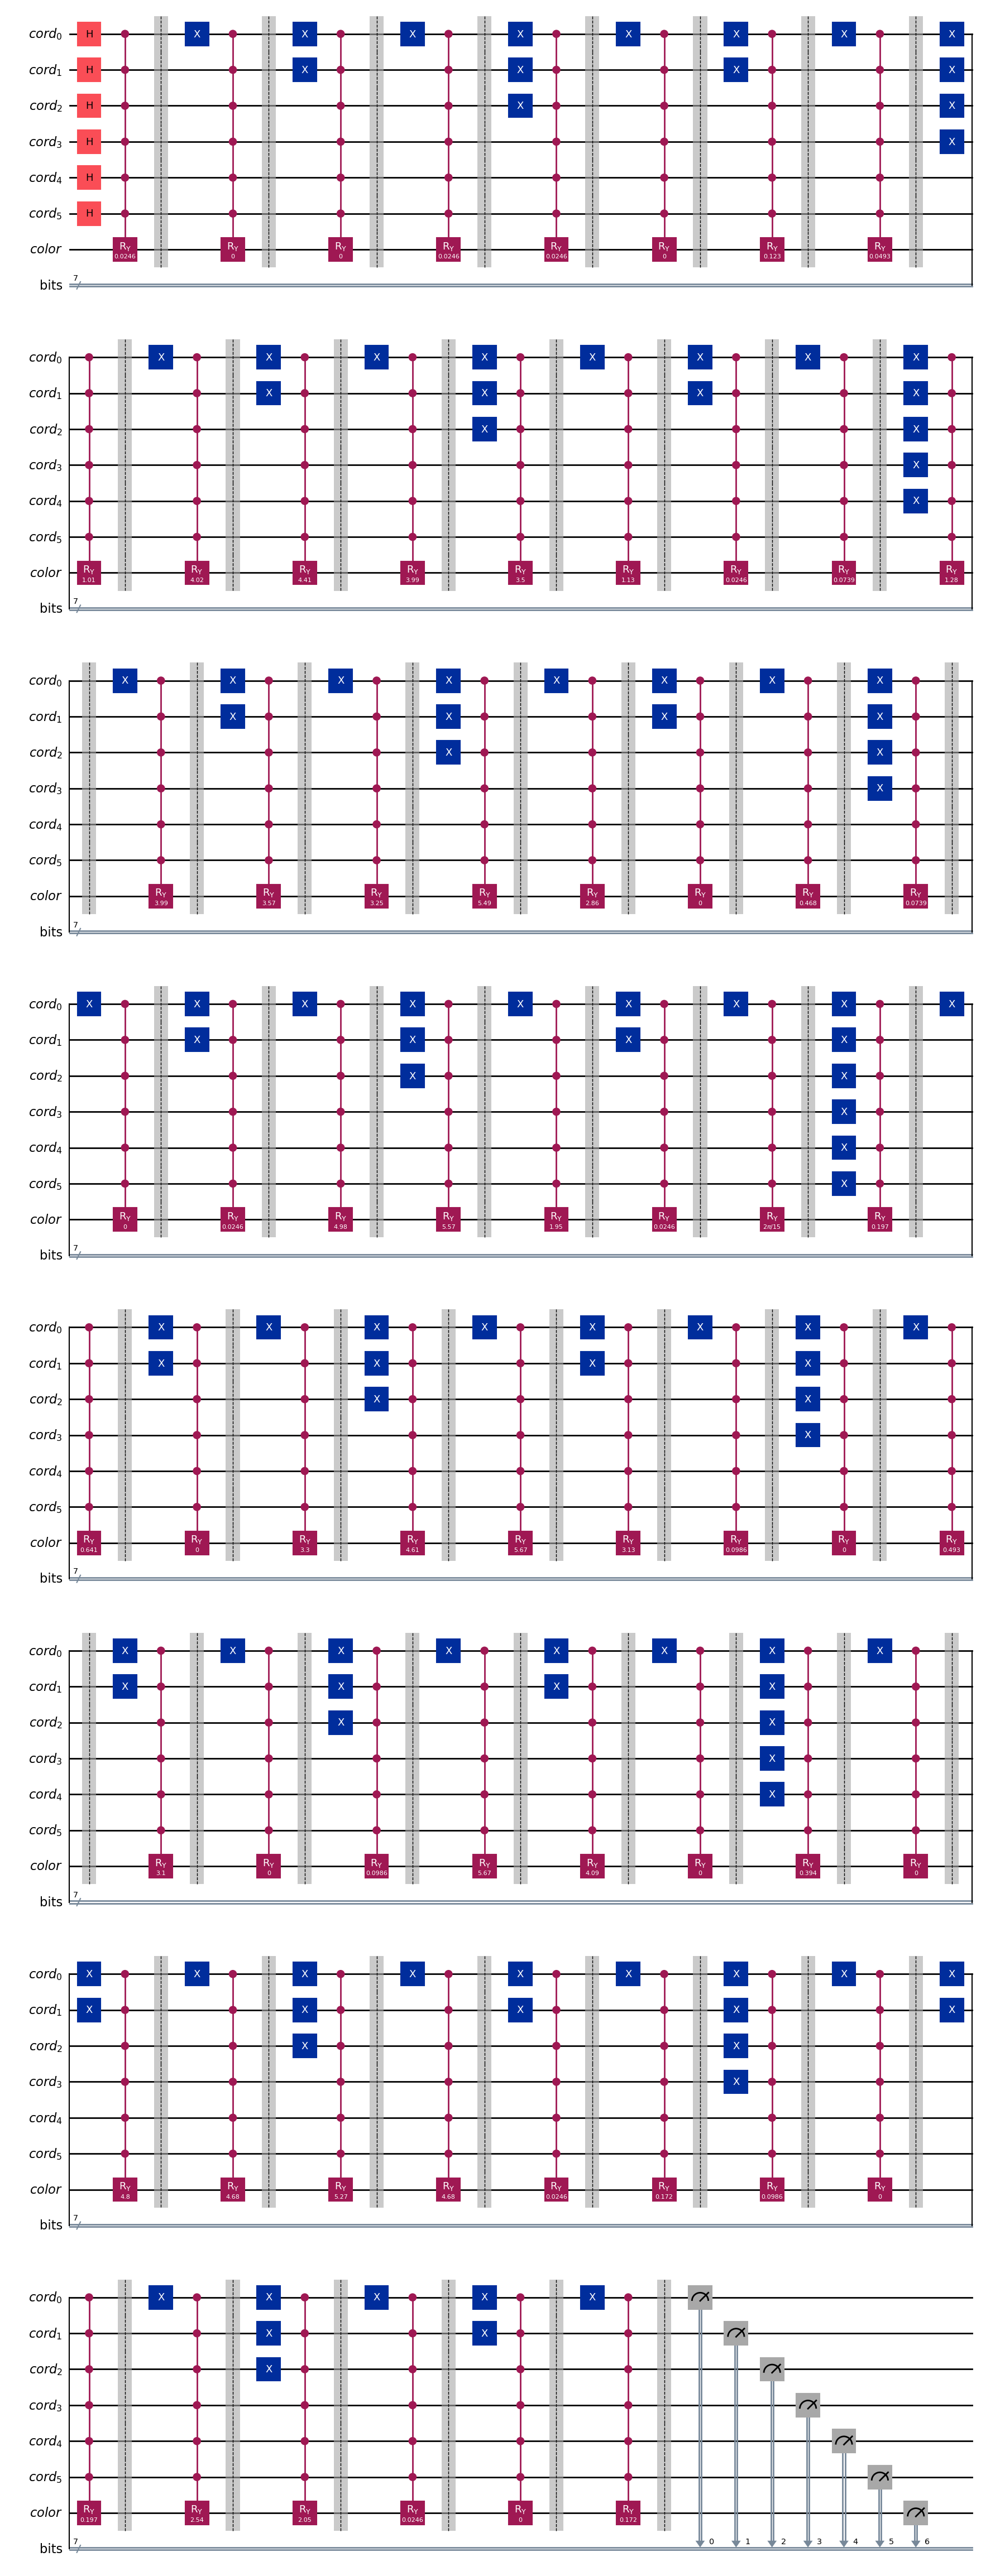

In [7]:
frqi_circ.draw(output='mpl')

In [8]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(frqi_circ, simulator)
shots = 100000
result = simulator.run(circuit, shots=shots).result()

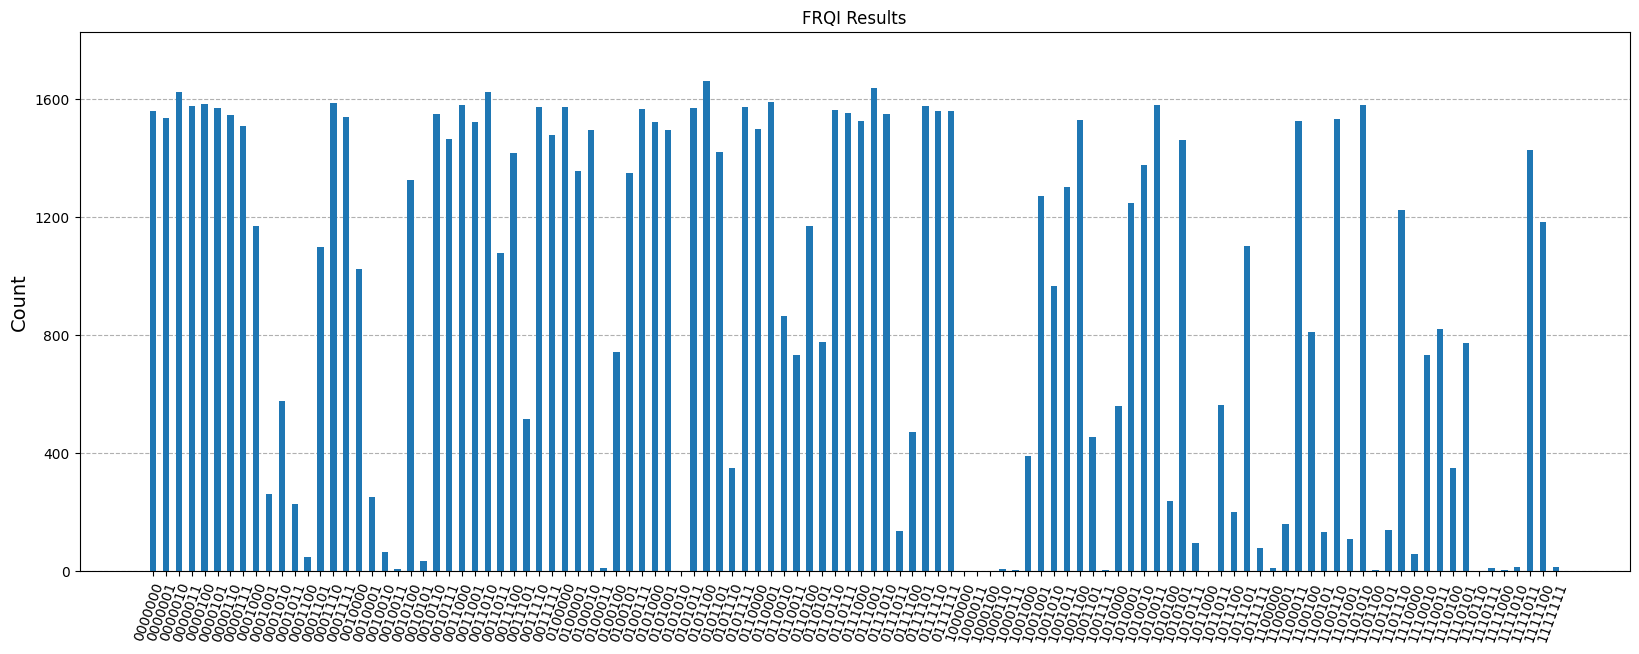

In [9]:
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(20, 7), title="FRQI Results", bar_labels=False)

In FRQI encoding, each pixel’s color intensity is represented by an angle $\theta_j$ stored in a quantum state. After running the FRQI circuit and measuring, each pixel coordinate yields counts for the color bits "0" and "1," where the frequency of "0" counts relates to the pixel's brightness. Specifically, the probability of observing "0" (i.e., $\cos^2(\theta_j)$) is calculated by dividing the "0" counts by the total counts for that pixel. Then, we retrieve the angle $\theta_j$ using the inverse cosine function, mapping it to the pixel’s grayscale intensity, with lower angles indicating brighter colors and higher angles indicating darker ones. 


In [10]:
n_pixels = len(flat_ang_rep)
retrieve_image = np.zeros(n_pixels)
num_qubits = frqi_circ.num_qubits

pixel_color_counts = {i: [] for i in range(n_pixels)}

for basis_state, count in counts.items():
    pixel_coord = int(basis_state[1:], 2)  # Extract pixel coordinate
    color_bit = int(basis_state[0])  # Extract color bit (0 or 1)
    pixel_color_counts[pixel_coord].append((color_bit, count))

# Calculate the color for each pixel based on the counts
#   the amplitude of the first qubit will tell us the intensity of the pixel.
classical_colors = []

for i in range(n_pixels):
    color_list = pixel_color_counts[i]
    
    # Sum the counts for each color bit (0 or 1) separately
    color_zero_count = sum(count for color_bit, count in color_list if color_bit == 0)
    total_count = sum(count for _, count in color_list)
    
    if total_count > 0:
        color = np.arccos(np.sqrt(color_zero_count / total_count))
        classical_colors.append(color)
    else:
        classical_colors.append(0)  

classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 255)).astype(int)))
classical_colors = np.fliplr(np.flipud(np.array(classical_colors).reshape(image.shape)))

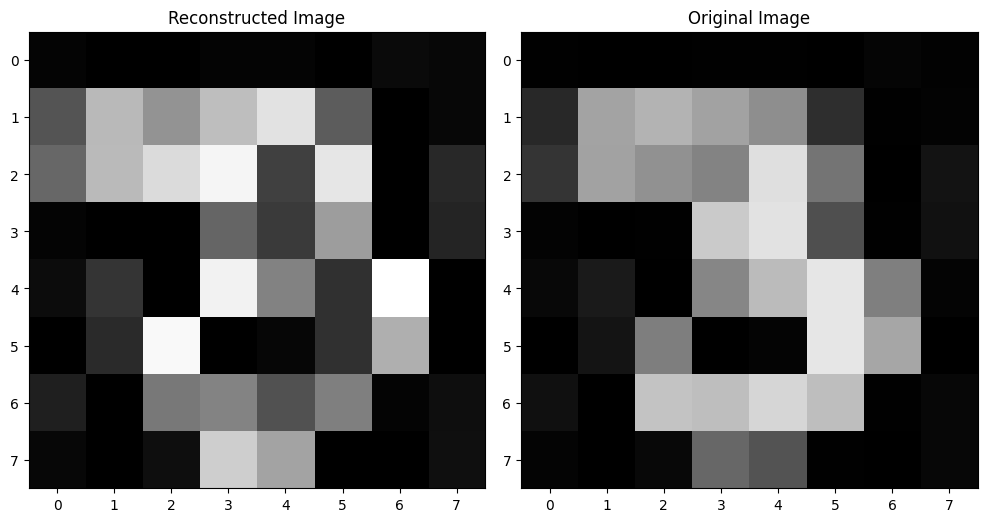

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(classical_colors, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Original Image')

plt.tight_layout()